In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1215

nband = 165

nv = 200

dv = 0.005

tsfc =294

ng =7

nref =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 7 /) 

data wgt
     &     /0.5 , 0.5 , 0.5 , 0.5,
     &     0.5 , 0.5 , 0.9/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /2 , 1.5 , 1.5 , 1.5,
     &     1.5 , 1.6 , 1.8/

klin =0

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

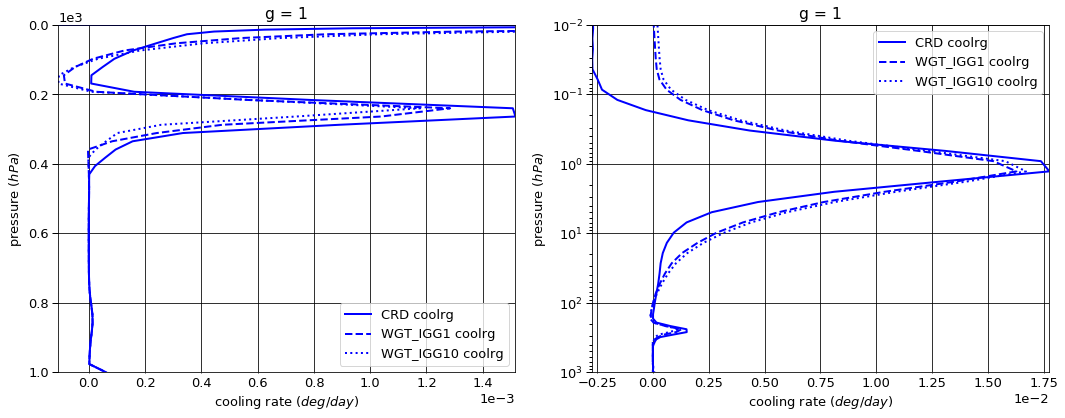

# Figure: cooling rate g-group 2

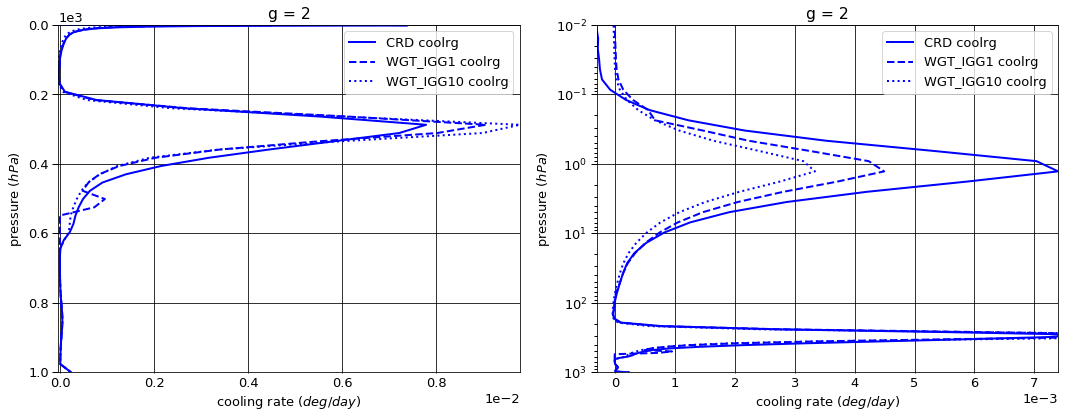

# Figure: cooling rate g-group 3

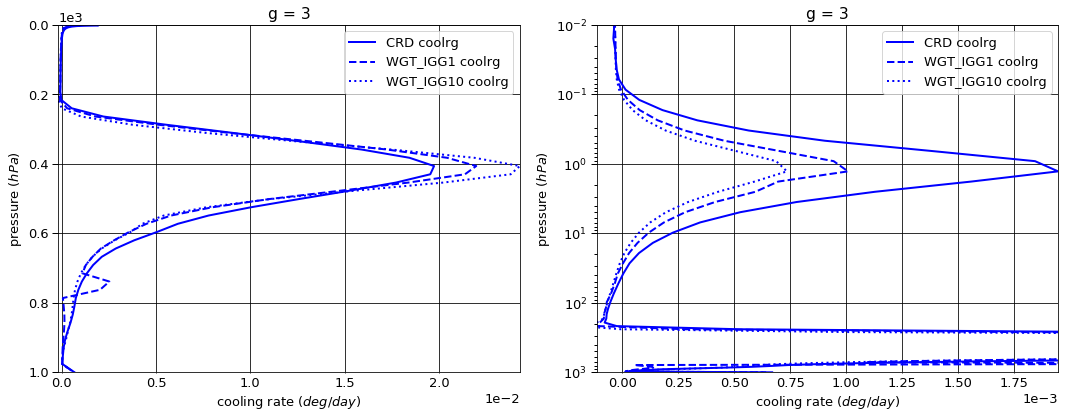

# Figure: cooling rate g-group 4

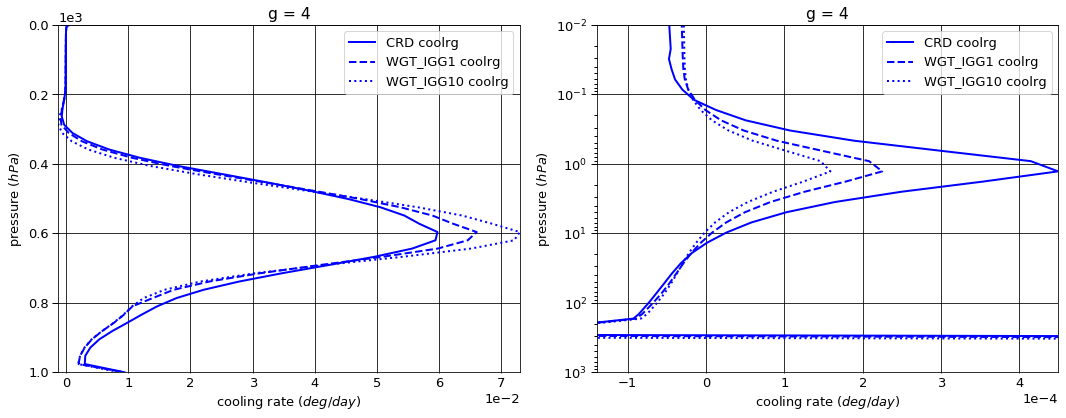

# Figure: cooling rate g-group 5

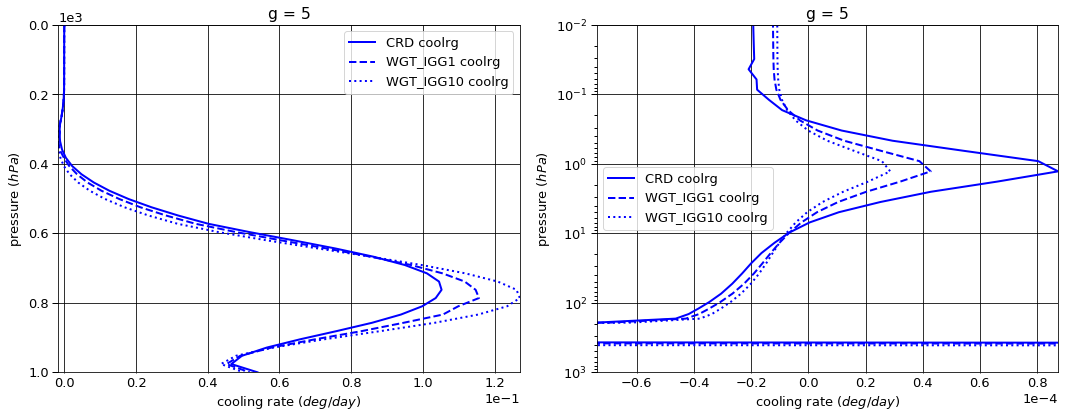

# Figure: cooling rate g-group 6

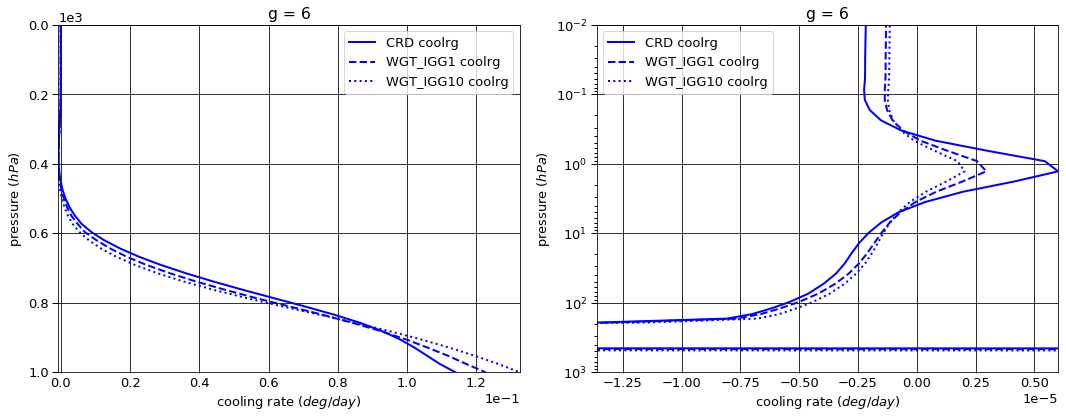

# Figure: cooling rate g-group 7

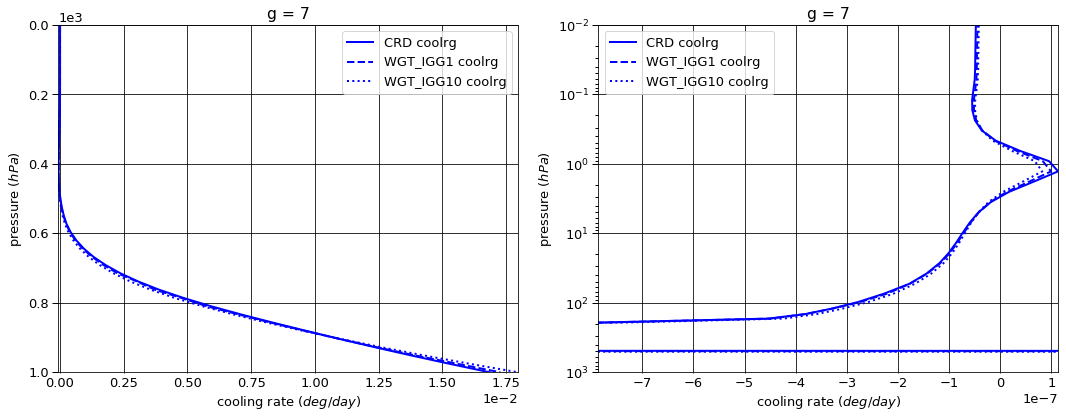

# Figure: cooling rate g-group total

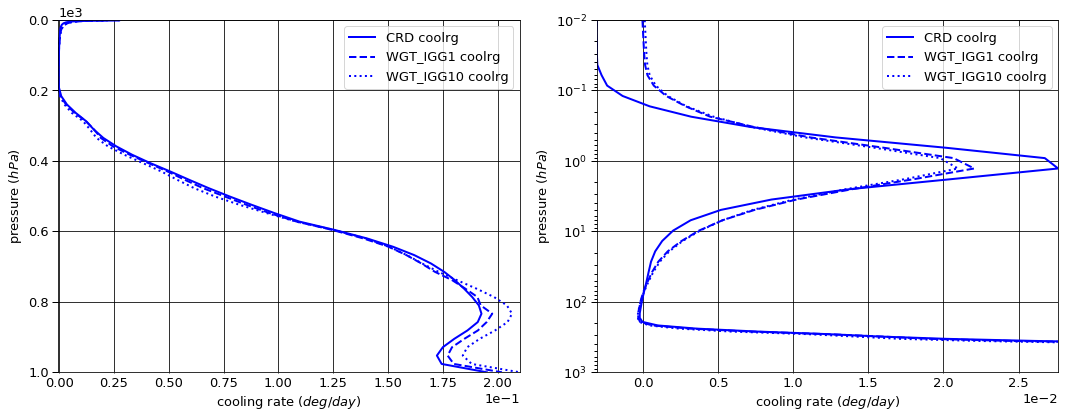

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024760  0.000000 -0.024760
  1013.0   76    -0.169095  0.168925 -0.000170
2 0.0      1     -0.131438  0.000000 -0.131438
  1013.0   76    -0.664080  0.663420 -0.000660
3 0.0      1     -0.552842  0.000000 -0.552842
  1013.0   76    -1.821021  1.819162 -0.001859
4 0.0      1     -2.225854  0.000000 -2.225854
  1013.0   76    -4.745903  4.718397 -0.027506
5 0.0      1     -4.734469  0.000000 -4.734469
  1013.0   76    -7.041643  6.676086 -0.365556
6 0.0      1     -6.306782  0.000000 -6.306782
  1013.0   76    -7.129284  4.069155 -3.060129
7 0.0      1     -2.121823  0.000000 -2.121823
  1013.0   76    -2.184150  0.400190 -1.783961


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.023607  0.000000 -0.023607
  1013.0   76    -0.169095  0.168925 -0.000170
2 0.0      1     -0.125267  0.000000 -0.125267
  1013.0   76    -0.664080  0.663420 -0.000660
3 0.0      1     -0.538515  0.000000 -0.538515
  1013.0   76    -1.821021  1.819225 -0.001796
4 0.0      1     -2.202259  0.000000 -2.202259
  1013.0   76    -4.745903  4.720864 -0.025039
5 0.0      1     -4.757086  0.000000 -4.757086
  1013.0   76    -7.041643  6.775247 -0.266396
6 0.0      1     -6.372796  0.000000 -6.372796
  1013.0   76    -7.129284  3.942681 -3.186603
7 0.0      1     -2.123008  0.000000 -2.123008
  1013.0   76    -2.184150  0.398541 -1.785609


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.023014  0.000000 -0.023014
  1013.0   76    -0.169095  0.168925 -0.000170
2 0.0      1     -0.126757  0.000000 -0.126757
  1013.0   76    -0.664080  0.663420 -0.000660
3 0.0      1     -0.546346  0.000000 -0.546346
  1013.0   76    -1.821021  1.819225 -0.001796
4 0.0      1     -2.238807  0.000000 -2.238807
  1013.0   76    -4.745903  4.723091 -0.022812
5 0.0      1     -4.834335  0.000000 -4.834335
  1013.0   76    -7.041643  6.801715 -0.239928
6 0.0      1     -6.425619  0.000000 -6.425619
  1013.0   76    -7.129284  3.910438 -3.218846
7 0.0      1     -2.125578  0.000000 -2.125578
  1013.0   76    -2.184150  0.395153 -1.788998


WGT_IGG1 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1      1.152609e-03  0.000000e+00  0.001153
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
2 0.0      1      6.171560e-03  0.000000e+00  0.006172
  1013.0   76     0.000000e+00  1.110223e-16  0.000000
3 0.0      1      1.432655e-02  0.000000e+00  0.014327
  1013.0   76    -2.220446e-16  6.250000e-05  0.000063
4 0.0      1      2.359590e-02  0.000000e+00  0.023596
  1013.0   76     0.000000e+00  2.467500e-03  0.002467
5 0.0      1     -2.261760e-02  0.000000e+00 -0.022618
  1013.0   76     8.881784e-16  9.916020e-02  0.099160
6 0.0      1     -6.601460e-02  0.000000e+00 -0.066015
  1013.0   76     0.000000e+00 -1.264741e-01 -0.126474
7 0.0      1     -1.184600e-03  0.000000e+00 -0.001185
  1013.0   76     0.000000e+00 -1.648560e-03 -0.001648


WGT_IGG10 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1      1.745899e-03  0.000000e+00  0.001746
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
2 0.0      1      4.681230e-03  0.000000e+00  0.004681
  1013.0   76     0.000000e+00  1.110223e-16  0.000000
3 0.0      1      6.496060e-03  0.000000e+00  0.006496
  1013.0   76    -2.220446e-16  6.250000e-05  0.000063
4 0.0      1     -1.295280e-02  0.000000e+00 -0.012953
  1013.0   76     0.000000e+00  4.694600e-03  0.004695
5 0.0      1     -9.986580e-02  0.000000e+00 -0.099866
  1013.0   76     8.881784e-16  1.256286e-01  0.125629
6 0.0      1     -1.188373e-01  0.000000e+00 -0.118837
  1013.0   76     0.000000e+00 -1.587172e-01 -0.158717
7 0.0      1     -3.754600e-03  0.000000e+00 -0.003755
  1013.0   76     0.000000e+00 -5.037200e-03 -0.005037

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.986786e-03
  1001.112500 75     6.089203e-05
2 0.000312    1     -3.587151e-04
  1001.112500 75     2.360915e-04
3 0.000312    1     -5.131326e-05
  1001.112500 75     6.692970e-04
4 0.000312    1     -5.217434e-05
  1001.112500 75     9.401687e-03
5 0.000312    1     -1.979343e-05
  1001.112500 75     5.388781e-02
6 0.000312    1     -2.082177e-06
  1001.112500 75     1.139846e-01
7 0.000312    1     -4.510862e-08
  1001.112500 75     1.686454e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.338796e-04
  1001.112500 75     6.089203e-05
2 0.000312    1     -4.526536e-05
  1001.112500 75     2.360915e-04
3 0.000312    1     -3.919951e-05
  1001.112500 75     6.424813e-04
4 0.000312    1     -3.338569e-05
  1001.112500 75     9.360385e-03
5 0.000312    1     -1.256968e-05
  1001.112500 75     5.170919e-02
6 0.000312    1     -1.250913e-06
  1001.112500 75     1.226972e-01
7 0.000312    1     -4.214261e-08
  1001.112500 75     1.727908e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.936497e-05
  1001.112500 75     6.089203e-05
2 0.000312    1     -5.103845e-05
  1001.112500 75     2.360915e-04
3 0.000312    1     -3.711107e-05
  1001.112500 75     6.424813e-04
4 0.000312    1     -2.999871e-05
  1001.112500 75     8.684848e-03
5 0.000312    1     -1.094657e-05
  1001.112500 75     4.996811e-02
6 0.000312    1     -1.096104e-06
  1001.112500 75     1.325695e-01
7 0.000312    1     -3.959688e-08
  1001.112500 75     1.797989e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.852906e-03
  1001.112500 75     6.776264e-21
2 0.000312    1      3.134497e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      1.211375e-05
  1001.112500 75    -2.681566e-05
4 0.000312    1      1.878865e-05
  1001.112500 75    -4.130190e-05
5 0.000312    1      7.223756e-06
  1001.112500 75    -2.178619e-03
6 0.000312    1      8.312643e-07
  1001.112500 75     8.712630e-03
7 0.000312    1      2.966014e-09
  1001.112500 75     4.145450e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.006151e-03
  1001.112500 75     6.776264e-21
2 0.000312    1      3.076766e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      1.420219e-05
  1001.112500 75    -2.681566e-05
4 0.000312    1      2.217563e-05
  1001.112500 75    -7.168383e-04
5 0.000312    1      8.846862e-06
  1001.112500 75    -3.919696e-03
6 0.000312    1      9.860734e-07
  1001.112500 75     1.858498e-02
7 0.000312    1      5.511742e-09
  1001.112500 75     1.115353e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.097968,0.000000,-16.097968
1013.0,76,-23.755176,18.515335,-5.239840



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.142538,0.000000,-16.142538
1013.0,76,-23.755176,18.488903,-5.266273



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.320455,0.000000,-16.320455
1013.0,76,-23.755176,18.481966,-5.273209



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.04457,0.000000,-0.044570
1013.0,76,0.00000,-0.026432,-0.026432



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.222487,0.000000,-0.222487
1013.0,76,0.000000,-0.033369,-0.033369


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003471
1001.112500,75,0.195105



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000266
1001.112500,75,0.201985



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000111
1001.112500,75,0.210142



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003205
1001.112500,75,0.006880



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003360
1001.112500,75,0.015037


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008455,0.006707
2,0.031727,0.026763
3,0.084848,0.074071
4,0.218515,0.193788
5,0.300788,0.294611
6,0.276970,0.307518
7,0.078697,0.096542


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.686315e-20
2,2.515606e-21
3,3.752724e-22
4,5.598228e-23
5,8.351308e-24
6,1.245829e-24
7,1.858499e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.686315e-20,NaN,0.008455,0.006707,0.008455,0.006707,600.0
2,2.515606e-21,0.149178,0.031727,0.026763,0.040182,0.033469,600.0
3,3.752724e-22,0.149178,0.084848,0.074071,0.125030,0.107541,600.0
4,5.598228e-23,0.149178,0.218515,0.193788,0.343545,0.301328,600.0
5,8.351308e-24,0.149178,0.300788,0.294611,0.644333,0.595939,600.0
6,1.245829e-24,0.149178,0.276970,0.307518,0.921303,0.903458,600.0
7,1.858499e-25,0.149178,0.078697,0.096542,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.914741e-20  1.486194e-21  19.612120  1.304396e-06
      2 0.000312     1.823362e-21  9.598001e-23  18.997312  8.172669e-08
      3 0.000312     1.441691e-22  1.080229e-23  13.346164  6.598772e-09
      4 0.000312     2.105078e-23  1.634532e-24  12.878784  9.659537e-10
      5 0.000312     3.194875e-24  2.078922e-25  15.367940  1.448918e-10
      6 0.000312     2.056684e-25  2.219042e-26   9.268341  9.702358e-12
      7 0.000312     1.195971e-26  2.388978e-27   5.006204  9.369973e-13
2     1 0.000750     2.928098e-20  1.488255e-21  19.674704  5.277197e-07
      2 0.000750     1.832007e-21  9.621750e-23  19.040272  3.307077e-08
      3 0.000750     1.448584e-22  1.082271e-23  13.384666  2.670070e-09
      4 0.000750     2.109181e-23  1.638017e-24  12.876428  3.898368e-10
      5 0.000750     3.204230e-24  2.084726e-25  15.370029  5.853088e-11
      6 0.000750     2.067394e-25  2.226660e-26   9.284733  3.927656e-12
      7 0.000750     1.202854e-26  2.396719e-27   5.018753  3.795614e-13
3     1 0.001052     2.956576e-20  1.492387e-21  19.811051  7.470156e-07
      2 0.001052     1.850476e-21  9.669984e-23  19.136289  4.683378e-08
      3 0.001052     1.463332e-22  1.086406e-23  13.469478  3.780934e-09
      4 0.001052     2.117966e-23  1.645125e-24  12.874195  5.489853e-10
      5 0.001052     3.224185e-24  2.096594e-25  15.378203  8.259138e-11
      6 0.001052     2.090295e-25  2.242493e-26   9.321300  5.566979e-12
      7 0.001052     1.217574e-26  2.412767e-27   5.046380  5.387414e-13
4     1 0.001476     2.986948e-20  1.496800e-21  19.955563  1.058379e-06
      2 0.001476     1.870213e-21  9.721313e-23  19.238273  6.638603e-08
      3 0.001476     1.479122e-22  1.090824e-23  13.559680  5.359011e-09
      4 0.001476     2.127385e-23  1.652725e-24  12.871980  7.736017e-10
      5 0.001476     3.245473e-24  2.109297e-25  15.386514  1.166279e-10
      6 0.001476     2.114808e-25  2.259458e-26   9.359800  7.898306e-12
      7 0.001476     1.233412e-26  2.430052e-27   5.075661  7.655322e-13
5     1 0.002070     3.017580e-20  1.501282e-21  20.100027  1.499178e-06
      2 0.002070     1.890160e-21  9.773145e-23  19.340343  9.408074e-08
      3 0.002070     1.495110e-22  1.095308e-23  13.650140  7.594269e-09
      4 0.002070     2.136939e-23  1.660443e-24  12.869688  1.089931e-09
      5 0.002070     3.266951e-24  2.122205e-25  15.394134  1.646584e-10
      6 0.002070     2.139624e-25  2.276691e-26   9.397952  1.120366e-11
      7 0.002070     1.249537e-26  2.447719e-27   5.104905  1.087630e-12
6     1 0.002904     3.048448e-20  1.505862e-21  20.243868  2.123750e-06
      2 0.002904     1.910301e-21  9.825683e-23  19.441917  1.333426e-07
      3 0.002904     1.511285e-22  1.099879e-23  13.740469  1.076318e-08
      4 0.002904     2.146622e-23  1.668308e-24  12.867064  1.535837e-09
      5 0.002904     3.288604e-24  2.135362e-25  15.400686  2.324974e-10
      6 0.002904     2.164726e-25  2.294228e-26   9.435530  1.589409e-11
      7 0.002904     1.265946e-26  2.465820e-27   5.133976  1.545508e-12
7     1 0.004074     3.079555e-20  1.510586e-21  20.386494  3.008549e-06
      2 0.004074     1.930639e-21  9.879287e-23  19.542291  1.889934e-07
      3 0.004074     1.527649e-22  1.104573e-23  13.830218  1.525507e-08
      4 0.004074     2.156438e-23  1.676369e-24  12.863744  2.164324e-09
      5 0.004074     3.310437e-24  2.148850e-25  15.405621  3.283000e-10
      6 0.004074     2.190119e-25  2.312141e-26   9.472257  2.254897e-11
      7 0.004074     1.282652e-26  2.484449e-27   5.162723  2.196348e-12
8     1 0.005714     3.110907e-20  1.515517e-21  20.527039  4.261630e-06
      2 0.005714     1.951176e-21  9.934475e-23  19.640451  2.678520e-07
      3 0.005714     1.544204e-22  1.109442e-23  13.918745  2.162060e-08
      4 0.005714     2.166390e-23  1.684698e-24  12.859216  3.049942e-09
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
